# Bibliotecas

Primero importamos las bibliotecas necesarias:

In [2]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.image as pltimg
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 8

# Preprocesado y modelado
# ------------------------------------------------------------------------------
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from joblib import Parallel, delayed, cpu_count
# Explicabilidad
import shap

# Configuración warnings
# ------------------------------------------------------------------------------
import multiprocessing
import warnings
warnings.filterwarnings('once')

# Lectura de los dataset y transformaciones

In [3]:
# Especificamos la ruta del archivo Excel
ruta_archivo_excel = 'Data_2 - copia.xlsx'

# Leemos todas las hojas del archivo Excel en un diccionario de DataFrames
P_data = pd.read_excel(ruta_archivo_excel, sheet_name='Product DATA')
T_data = pd.read_excel(ruta_archivo_excel, sheet_name='Transaction DATA')
B_data = pd.read_excel(ruta_archivo_excel, sheet_name='Budget Data')
W_data = pd.read_excel(ruta_archivo_excel, sheet_name='Weather DATA')

In [4]:
# Eliminamos todas las filas que pertenezcan a productos distintos de ['PROD_00001', 'PROD_00002', 'PROD_00004']
P_data = P_data[P_data['PROD_ID'].isin([1, 2, 4])]


In [5]:
# Quitamos las filas con horas fuera de horario de parque (12.0-20.0)
W_df = W_data[(W_data['WEATHER_HOUR'] <= 20.0) & (W_data['WEATHER_HOUR'] >= 12.0)]

In [6]:
# Unimos todas las tablas
df = pd.merge(T_data, P_data, on='PROD_ID', how='left')
df = pd.merge(df, W_df, left_on='TRX_TARGET_DATE', right_on='WEATHER_DATE', how='left')
# Rellenamos la columna TRX_DISCOUNT_CODE con YES o NO
df['TRX_DISCOUNT_CODE'] = df['PRICE_DISC_PERC'].apply(lambda x: 'YES' if x != 0.0 else 'NO')
df = df.dropna()

In [7]:
# Eliminamos los registros donde PRICE_FINAL es igual a 0
df = df[df['PRICE_FINAL'] != 0]

In [8]:
# Convertimos las columnas a datetime
df['TRX_TARGET_DATE'] = pd.to_datetime(df['TRX_TARGET_DATE'], errors='coerce')
df['TRX_DATE'] = pd.to_datetime(df['TRX_DATE'], errors='coerce')

# Función personalizada para rellenar los valores
def fill_target_date(row):
    if pd.isna(row['TRX_TARGET_DATE']):
        return row['TRX_DATE']
    return row['TRX_TARGET_DATE']

# Aplicamos la función a cada fila del DataFrame
df['TRX_TARGET_DATE'] = df.apply(fill_target_date, axis=1)

# Función para determinar la temporada según la fecha
def get_season(date):
    year = date.year
    seasons = {
        'spring': (pd.Timestamp(year=year, month=3, day=20), pd.Timestamp(year=year, month=6, day=20)),
        'summer': (pd.Timestamp(year=year, month=6, day=21), pd.Timestamp(year=year, month=9, day=22)),
        'autumn': (pd.Timestamp(year=year, month=9, day=23), pd.Timestamp(year=year, month=12, day=20)),
        'winter': (pd.Timestamp(year=year, month=12, day=21), pd.Timestamp(year=year+1, month=3, day=19)),
    }
    
    for season, (start, end) in seasons.items():
        if start <= date <= end:
            return season
    return 'invierno'  # Para fechas en enero y febrero antes del inicio de la primavera

# Añadimos una nueva columna 'temporada' al DataFrame
df['Season'] = df['TRX_TARGET_DATE'].apply(get_season)
df['DayOfWeek'] = df['TRX_TARGET_DATE'].dt.day_name()

In [9]:
# Eliminamos las columnas que no usaremos para el modelo
df = df.drop(columns=['TRX_ID','TRX_DATE','TRX_TARGET_DATE','TRX_DISCOUNT_CODE','PRICE_INITIAL',
                      'PROD_DESC','PROD_CAT','WEATHER_DATE','WEATHER_HOUR','PRICE_DISC_PERC'])
df = df.dropna()

In [10]:
df.to_csv('data_arreglada.csv', index=False)

In [11]:
df = pd.read_csv('data_arreglada.csv')

In [12]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596078 entries, 0 to 1596077
Data columns (total 10 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   PROD_ID       1596078 non-null  float64
 1   PRICE_FINAL   1596078 non-null  float64
 2   N_DAYS        1596078 non-null  int64  
 3   WEATHER_ID    1596078 non-null  object 
 4   TEMP          1596078 non-null  float64
 5   TEMP_MIN      1596078 non-null  float64
 6   TEMP_MAX      1596078 non-null  float64
 7   TEM_HUMIDITY  1596078 non-null  float64
 8   Season        1596078 non-null  object 
 9   DayOfWeek     1596078 non-null  object 
dtypes: float64(6), int64(1), object(3)
memory usage: 121.8+ MB
None


## Preprocesamiento del dataset

Creamos una capa de normalización que usaremos dentro de los modelos:

In [13]:
# One-hot-encoding
# Primero identificamos las variables categóricas
cat_cols = df.select_dtypes(include=['object', 'category']).columns.to_list()
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.to_list()

# Aplicamos one-hot-encoding sólo a las columnas categóricas
preprocessor = ColumnTransformer(
                    [('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary'), cat_cols)],
                    remainder='passthrough',
                    verbose_feature_names_out=False).set_output(transform="pandas")

# Algoritmos para cada tipo de entrada

## Modelo 1: Árbol de regresión


Creando modelo Árbol de regresión para el tipo de producto: 1


C:\Users\fjuan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


Profundidad del árbol: 5
Número de nodos terminales: 32


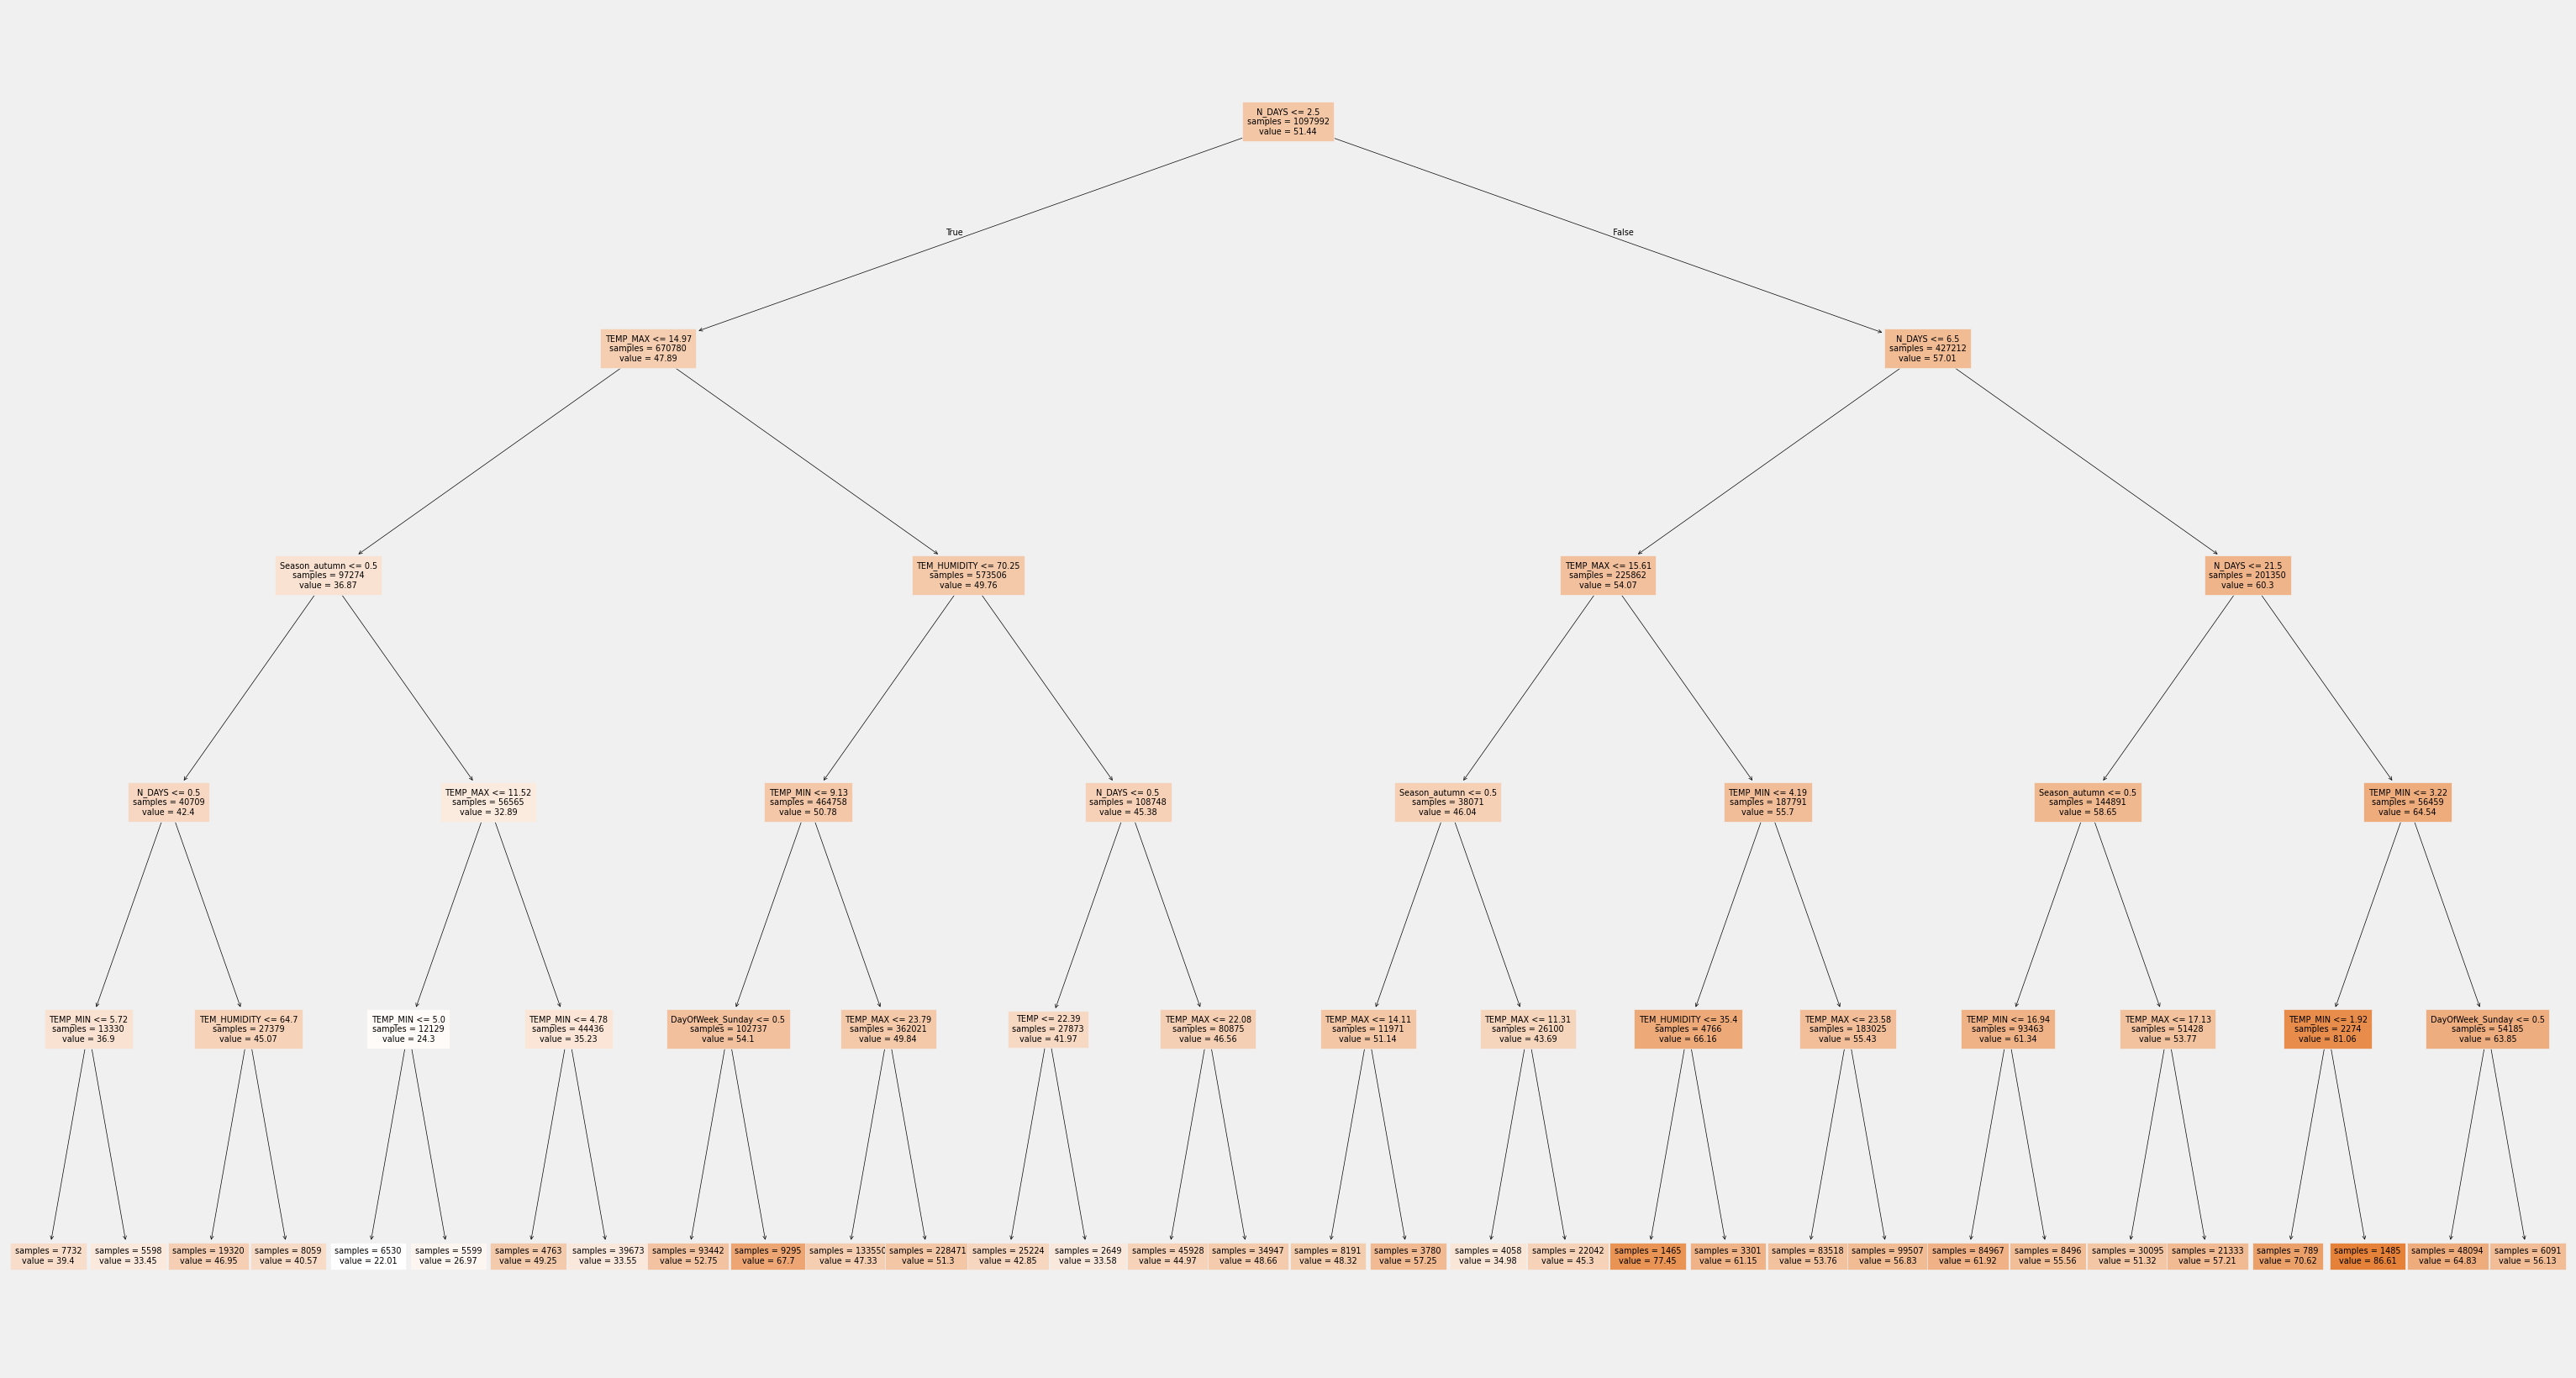

Reglas de decisión modelo inicial:
|--- N_DAYS <= 2.50
|   |--- TEMP_MAX <= 14.97
|   |   |--- Season_autumn <= 0.50
|   |   |   |--- N_DAYS <= 0.50
|   |   |   |   |--- TEMP_MIN <= 5.72
|   |   |   |   |   |--- value: [39.40]
|   |   |   |   |--- TEMP_MIN >  5.72
|   |   |   |   |   |--- value: [33.45]
|   |   |   |--- N_DAYS >  0.50
|   |   |   |   |--- TEM_HUMIDITY <= 64.70
|   |   |   |   |   |--- value: [46.95]
|   |   |   |   |--- TEM_HUMIDITY >  64.70
|   |   |   |   |   |--- value: [40.57]
|   |   |--- Season_autumn >  0.50
|   |   |   |--- TEMP_MAX <= 11.52
|   |   |   |   |--- TEMP_MIN <= 5.00
|   |   |   |   |   |--- value: [22.01]
|   |   |   |   |--- TEMP_MIN >  5.00
|   |   |   |   |   |--- value: [26.97]
|   |   |   |--- TEMP_MAX >  11.52
|   |   |   |   |--- TEMP_MIN <= 4.78
|   |   |   |   |   |--- value: [49.25]
|   |   |   |   |--- TEMP_MIN >  4.78
|   |   |   |   |   |--- value: [33.55]
|   |--- TEMP_MAX >  14.97
|   |   |--- TEM_HUMIDITY <= 70.25
|   |   |   |--- T

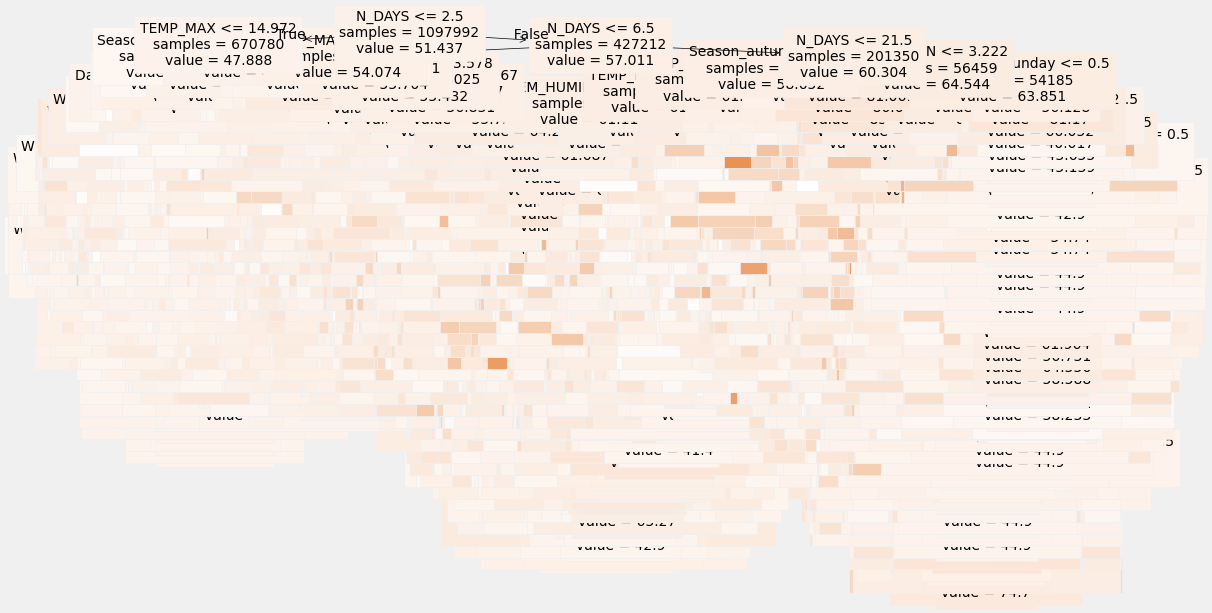

Importancia de los predictores en el modelo final
-------------------------------------------
                          predictor   importancia
23                           N_DAYS  3.596740e-01
25                         TEMP_MIN  1.934007e-01
26                         TEMP_MAX  1.579252e-01
27                     TEM_HUMIDITY  6.551804e-02
24                             TEMP  5.205282e-02
16                 DayOfWeek_Friday  2.236565e-02
13                    Season_autumn  1.986723e-02
18               DayOfWeek_Saturday  1.840469e-02
21                DayOfWeek_Tuesday  1.568036e-02
19                 DayOfWeek_Sunday  1.404882e-02
20               DayOfWeek_Thursday  1.403786e-02
22              DayOfWeek_Wednesday  1.245637e-02
15                    Season_summer  1.197256e-02
14                    Season_spring  1.188354e-02
17                 DayOfWeek_Monday  8.612173e-03
12  WEATHER_ID_SHOWERSINTHEVICINITY  5.930087e-03
0                 WEATHER_ID_CLOUDY  4.058125e-03
2     

C:\Users\fjuan\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\fjuan\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Profundidad del árbol: 5
Número de nodos terminales: 32


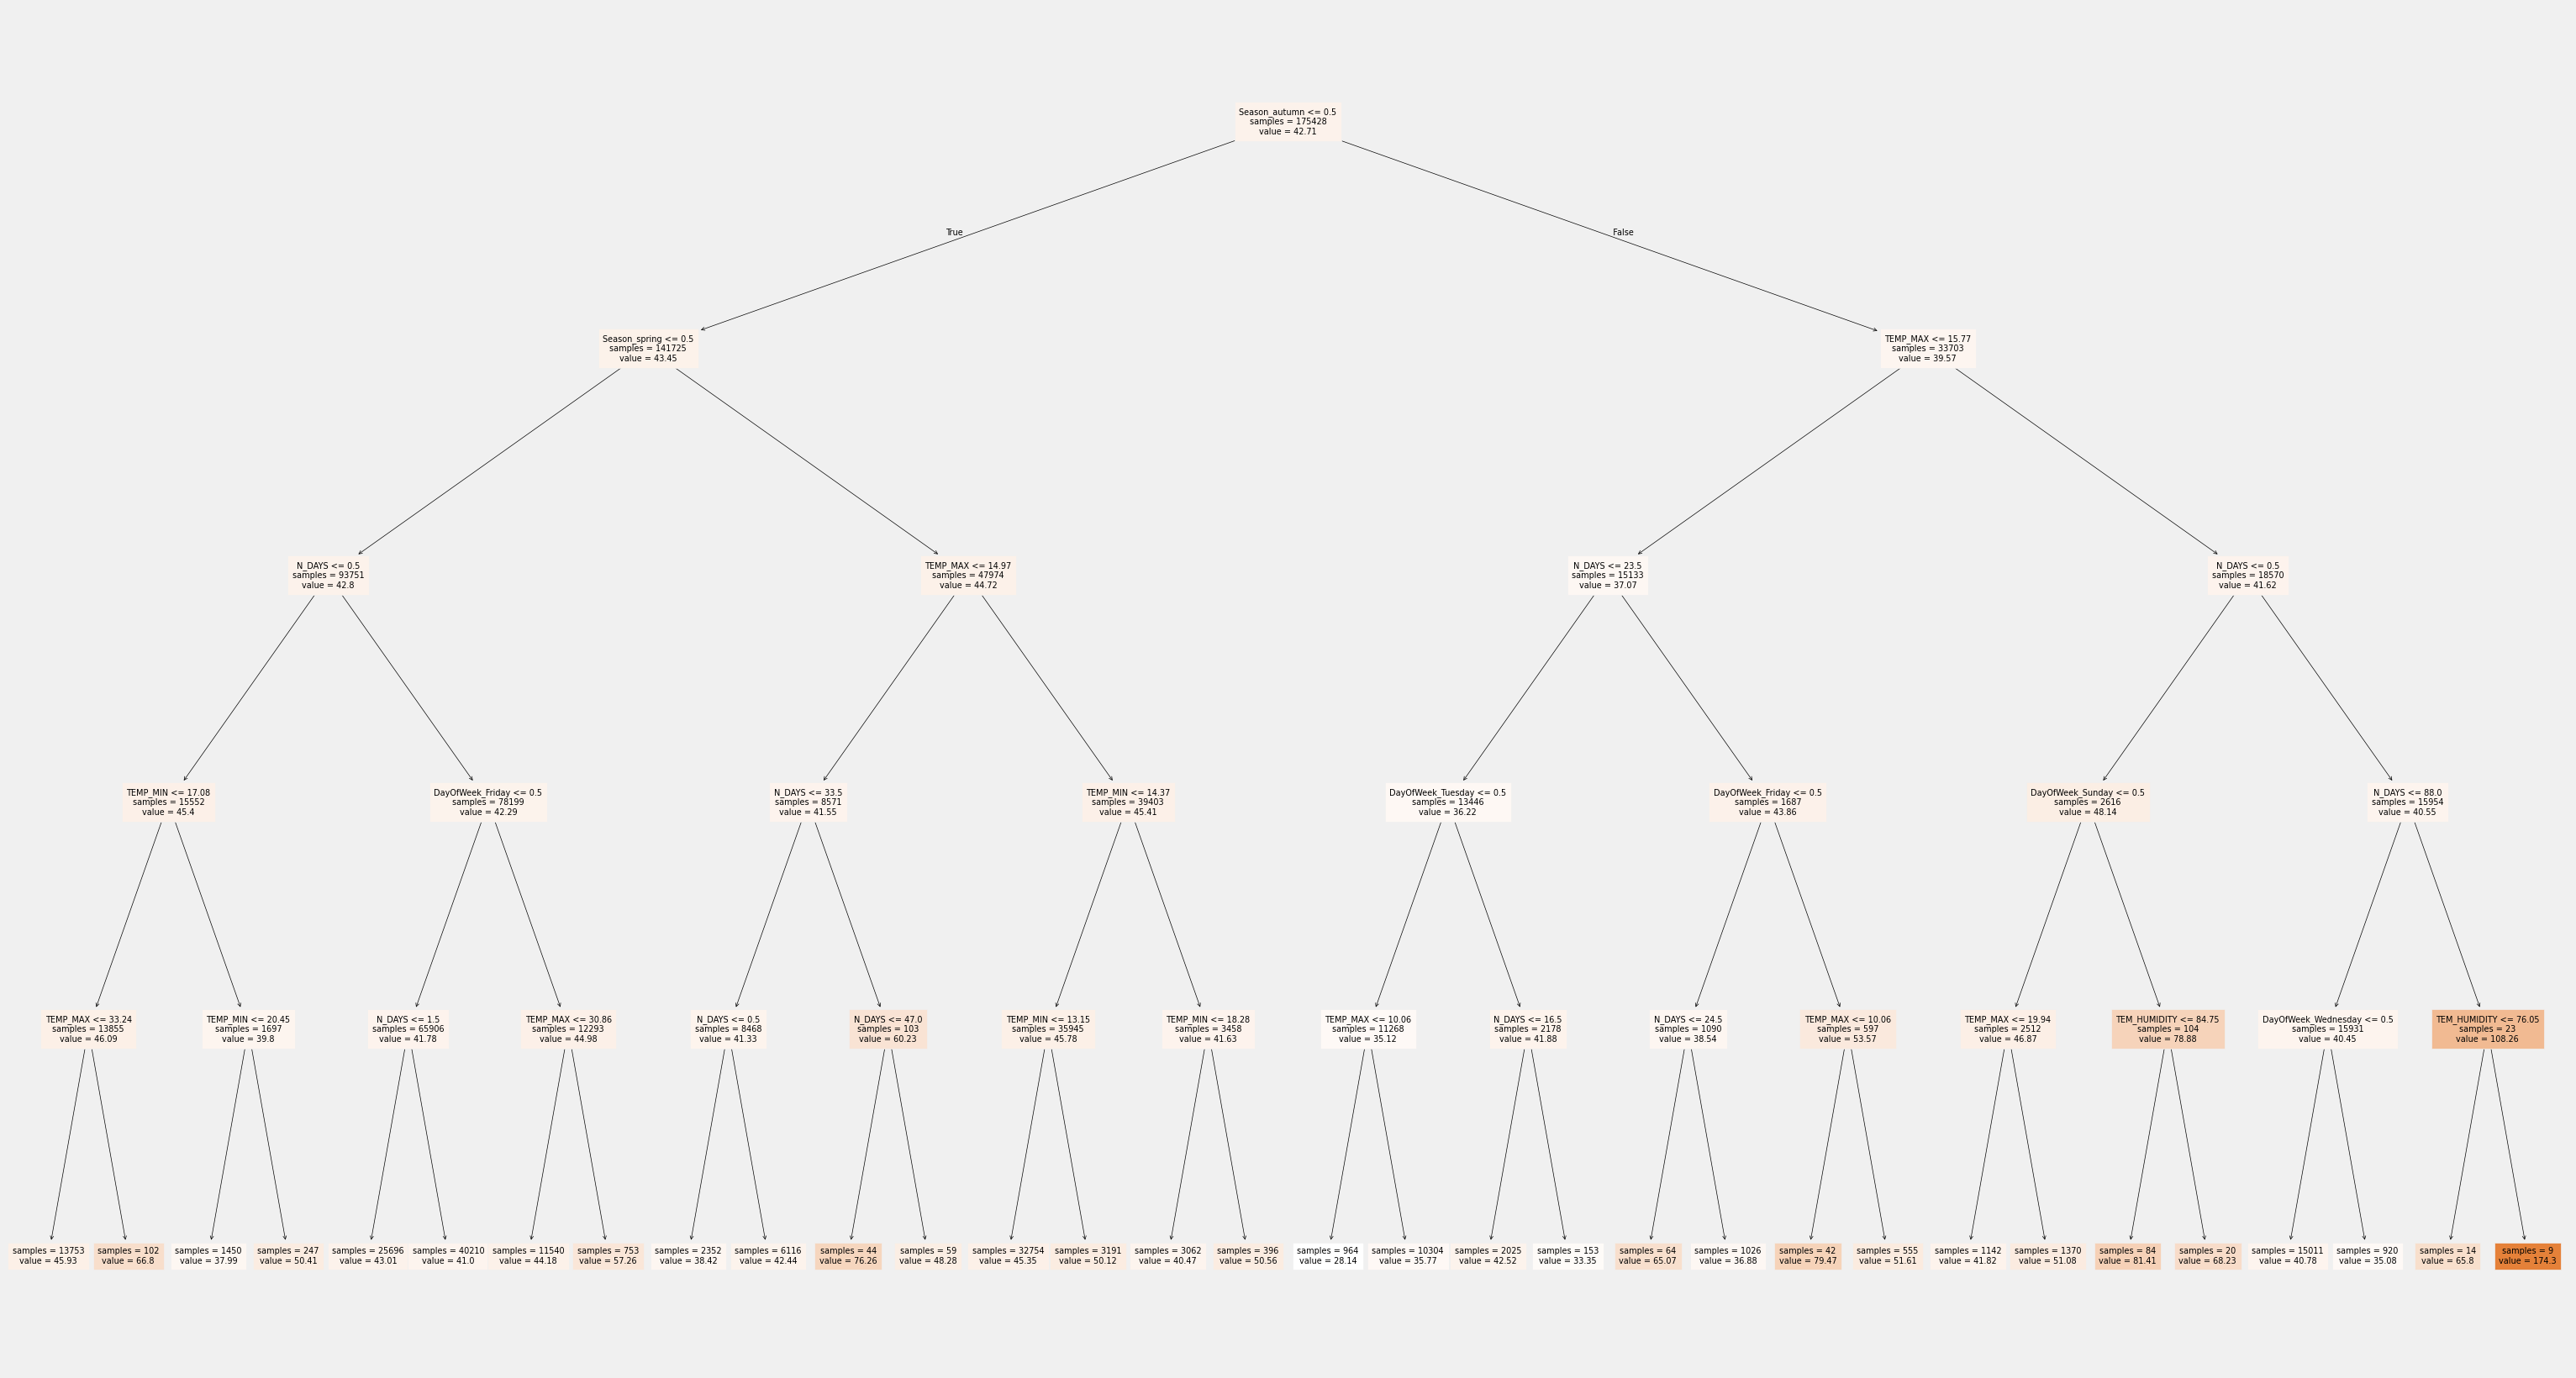

Reglas de decisión modelo inicial:
|--- Season_autumn <= 0.50
|   |--- Season_spring <= 0.50
|   |   |--- N_DAYS <= 0.50
|   |   |   |--- TEMP_MIN <= 17.08
|   |   |   |   |--- TEMP_MAX <= 33.24
|   |   |   |   |   |--- value: [45.93]
|   |   |   |   |--- TEMP_MAX >  33.24
|   |   |   |   |   |--- value: [66.80]
|   |   |   |--- TEMP_MIN >  17.08
|   |   |   |   |--- TEMP_MIN <= 20.45
|   |   |   |   |   |--- value: [37.99]
|   |   |   |   |--- TEMP_MIN >  20.45
|   |   |   |   |   |--- value: [50.41]
|   |   |--- N_DAYS >  0.50
|   |   |   |--- DayOfWeek_Friday <= 0.50
|   |   |   |   |--- N_DAYS <= 1.50
|   |   |   |   |   |--- value: [43.01]
|   |   |   |   |--- N_DAYS >  1.50
|   |   |   |   |   |--- value: [41.00]
|   |   |   |--- DayOfWeek_Friday >  0.50
|   |   |   |   |--- TEMP_MAX <= 30.86
|   |   |   |   |   |--- value: [44.18]
|   |   |   |   |--- TEMP_MAX >  30.86
|   |   |   |   |   |--- value: [57.26]
|   |--- Season_spring >  0.50
|   |   |--- TEMP_MAX <= 14.97
|   |   |

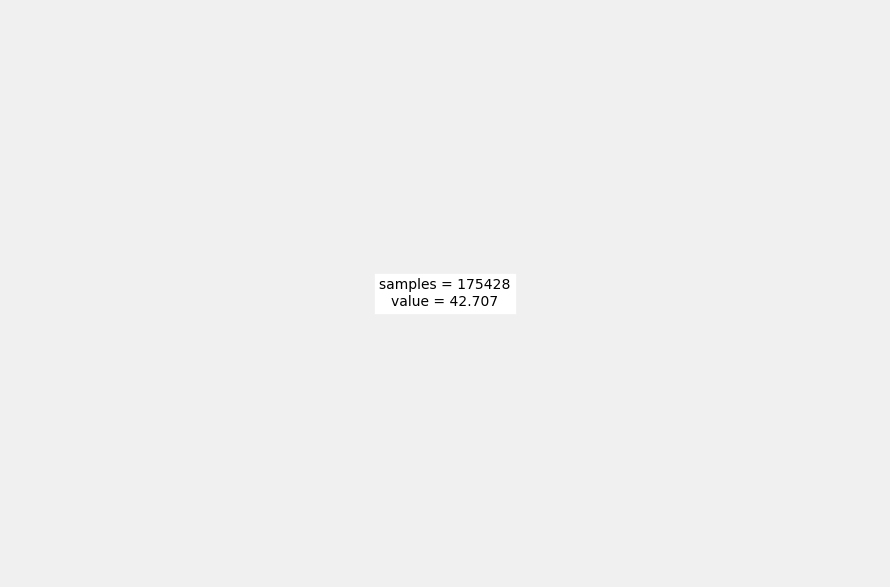

Importancia de los predictores en el modelo final
-------------------------------------------
                          predictor  importancia
0                 WEATHER_ID_CLOUDY          0.0
1                WEATHER_ID_DRIZZLE          0.0
26                         TEMP_MAX          0.0
25                         TEMP_MIN          0.0
24                             TEMP          0.0
23                           N_DAYS          0.0
22              DayOfWeek_Wednesday          0.0
21                DayOfWeek_Tuesday          0.0
20               DayOfWeek_Thursday          0.0
19                 DayOfWeek_Sunday          0.0
18               DayOfWeek_Saturday          0.0
17                 DayOfWeek_Monday          0.0
16                 DayOfWeek_Friday          0.0
15                    Season_summer          0.0
14                    Season_spring          0.0
13                    Season_autumn          0.0
12  WEATHER_ID_SHOWERSINTHEVICINITY          0.0
11           WEATHER_ID_

C:\Users\fjuan\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\fjuan\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


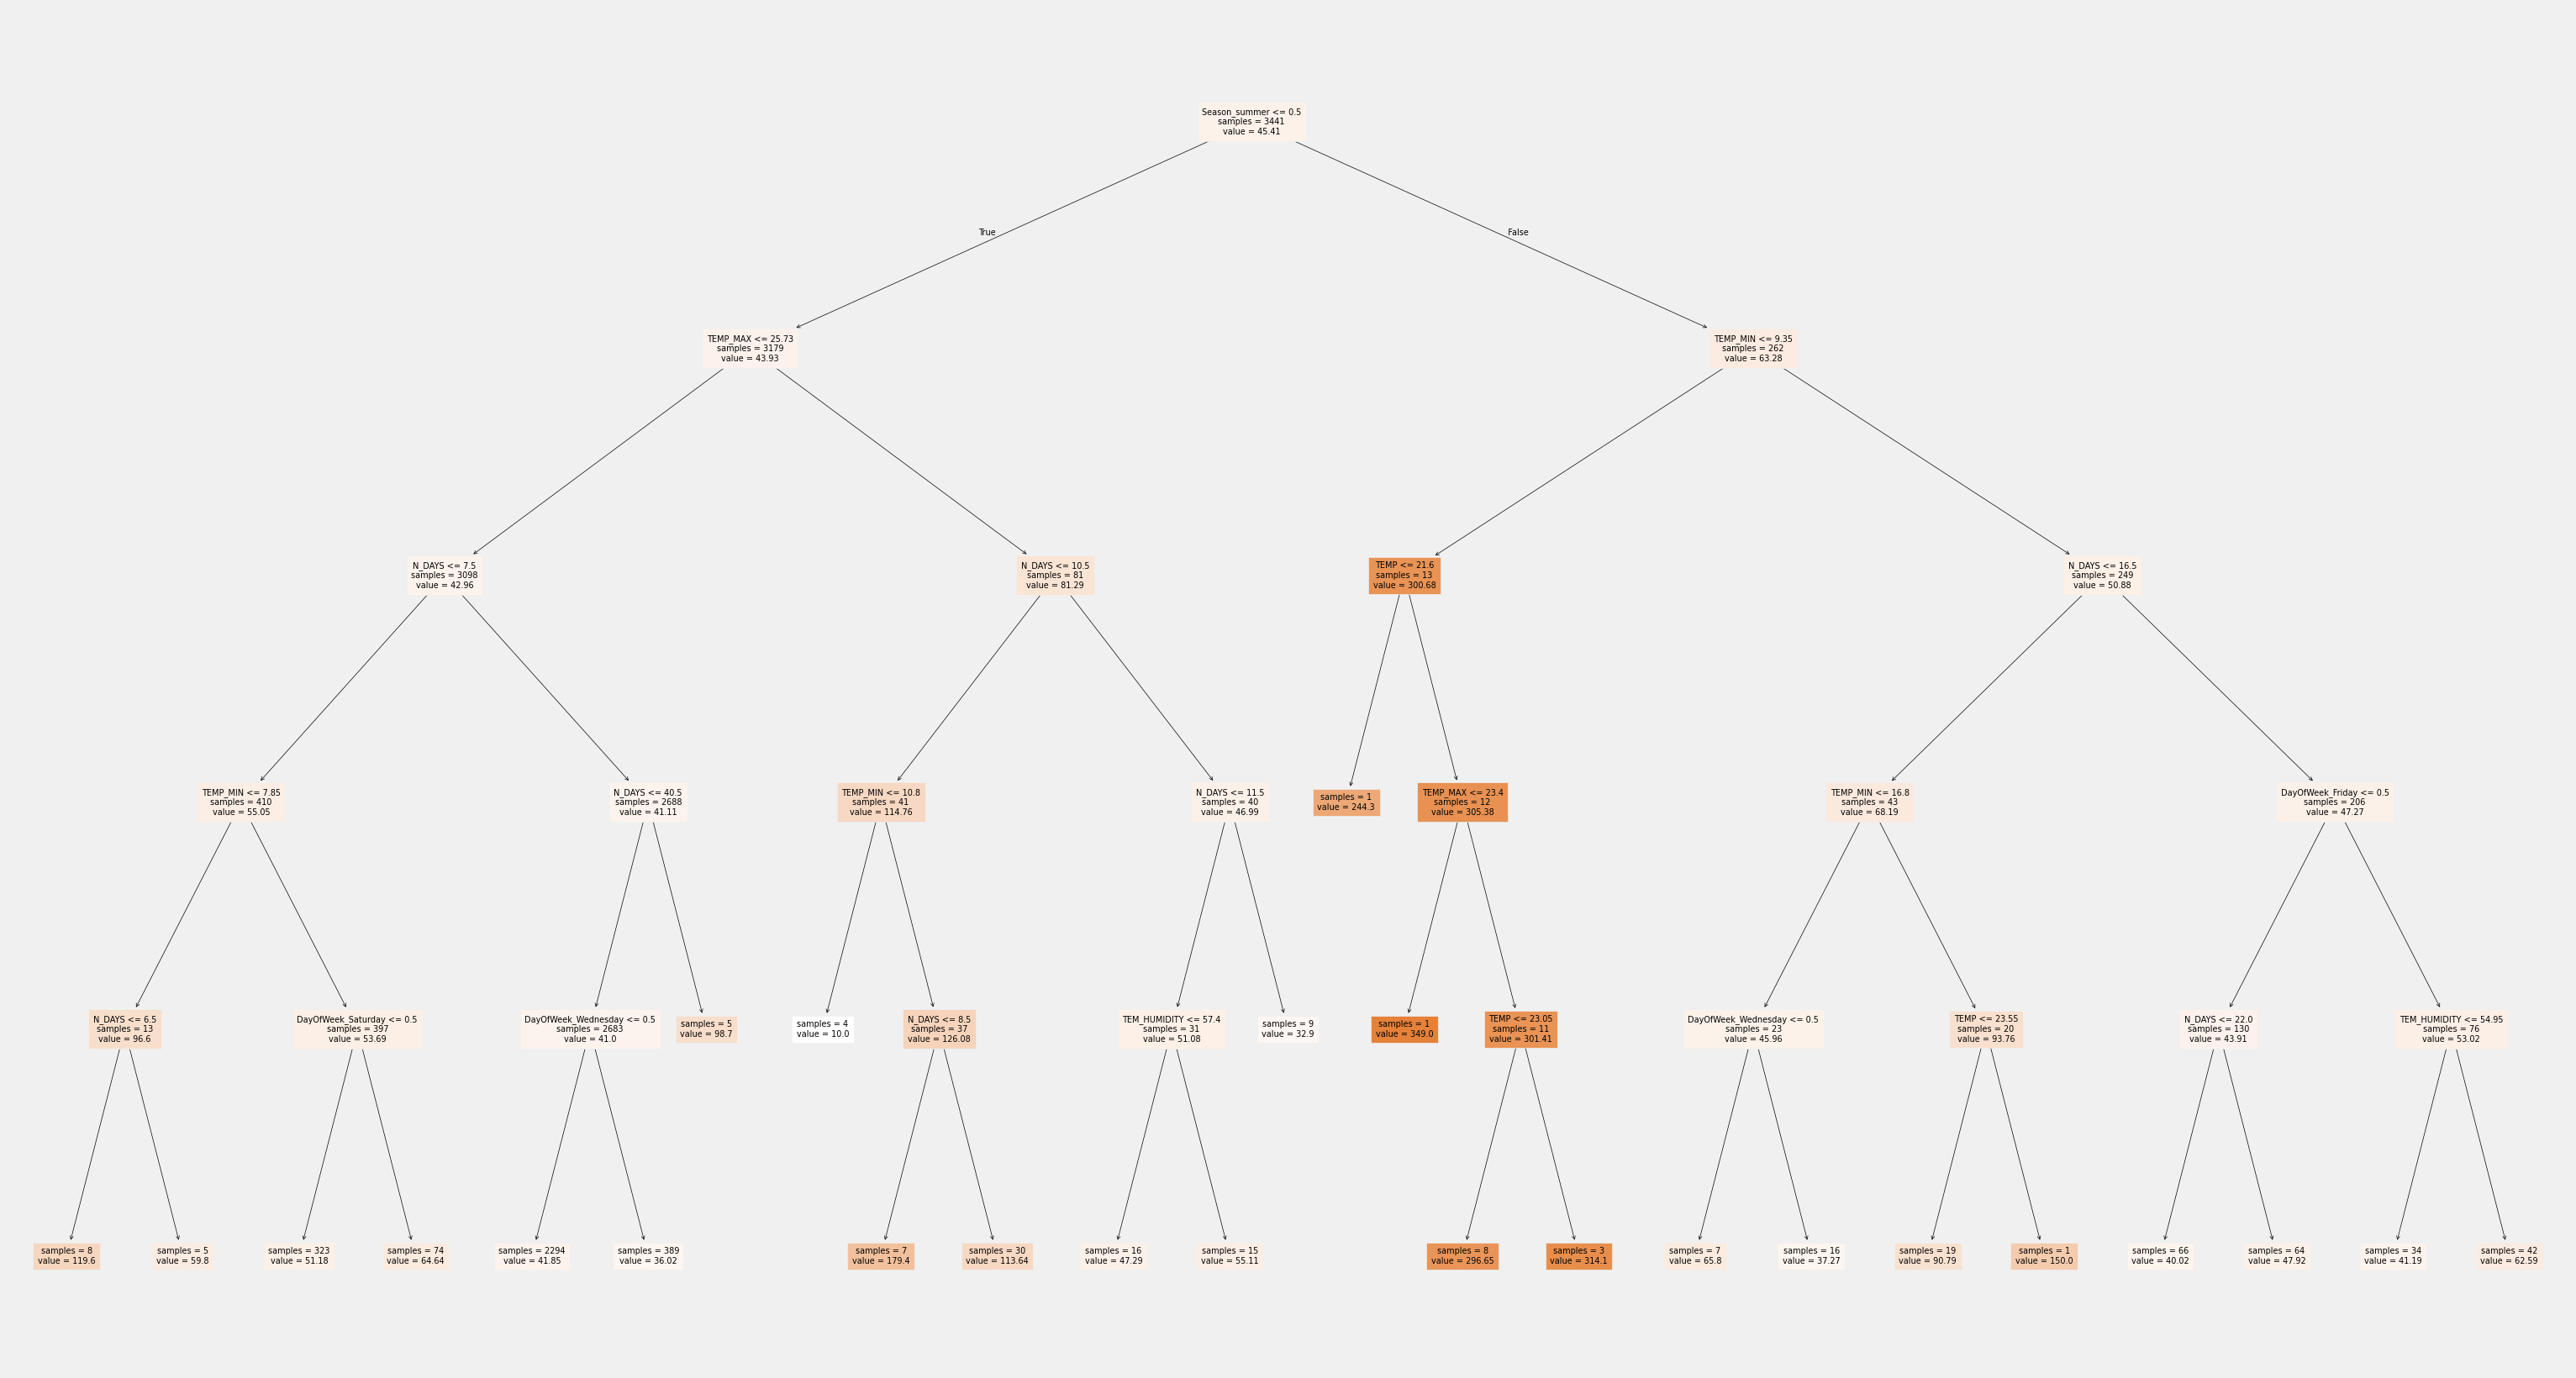

Reglas de decisión modelo inicial:
|--- Season_summer <= 0.50
|   |--- TEMP_MAX <= 25.73
|   |   |--- N_DAYS <= 7.50
|   |   |   |--- TEMP_MIN <= 7.85
|   |   |   |   |--- N_DAYS <= 6.50
|   |   |   |   |   |--- value: [119.60]
|   |   |   |   |--- N_DAYS >  6.50
|   |   |   |   |   |--- value: [59.80]
|   |   |   |--- TEMP_MIN >  7.85
|   |   |   |   |--- DayOfWeek_Saturday <= 0.50
|   |   |   |   |   |--- value: [51.18]
|   |   |   |   |--- DayOfWeek_Saturday >  0.50
|   |   |   |   |   |--- value: [64.64]
|   |   |--- N_DAYS >  7.50
|   |   |   |--- N_DAYS <= 40.50
|   |   |   |   |--- DayOfWeek_Wednesday <= 0.50
|   |   |   |   |   |--- value: [41.85]
|   |   |   |   |--- DayOfWeek_Wednesday >  0.50
|   |   |   |   |   |--- value: [36.02]
|   |   |   |--- N_DAYS >  40.50
|   |   |   |   |--- value: [98.70]
|   |--- TEMP_MAX >  25.73
|   |   |--- N_DAYS <= 10.50
|   |   |   |--- TEMP_MIN <= 10.80
|   |   |   |   |--- value: [10.00]
|   |   |   |--- TEMP_MIN >  10.80
|   |   |   |   

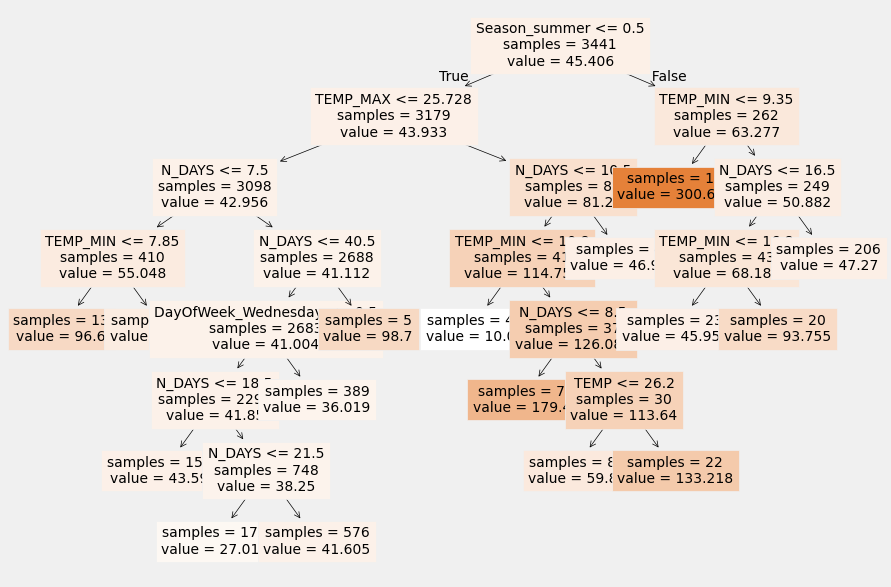

Importancia de los predictores en el modelo final
-------------------------------------------
                          predictor  importancia
17                         TEMP_MIN     0.629275
15                           N_DAYS     0.189673
18                         TEMP_MAX     0.084174
7                     Season_summer     0.065725
16                             TEMP     0.022947
14              DayOfWeek_Wednesday     0.008205
0                 WEATHER_ID_CLOUDY     0.000000
11                 DayOfWeek_Sunday     0.000000
13                DayOfWeek_Tuesday     0.000000
12               DayOfWeek_Thursday     0.000000
10               DayOfWeek_Saturday     0.000000
1                   WEATHER_ID_FAIR     0.000000
9                  DayOfWeek_Monday     0.000000
8                  DayOfWeek_Friday     0.000000
6   WEATHER_ID_SHOWERSINTHEVICINITY     0.000000
5                   WEATHER_ID_RAIN     0.000000
4           WEATHER_ID_PARTLYCLOUDY     0.000000
3           WEATHER_ID_M

C:\Users\fjuan\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\fjuan\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [13]:
productos = [1,2,4]
for producto in productos:
    print(f"\nCreando modelo Árbol de regresión para el tipo de entrada: {producto}")
    
    # Filtramos los datos para el tipo de producto actual
    df_producto = df[df['PROD_ID'] == producto]
    
    # Preprocesamos el dataframe que usaremos para el modelo
    df_producto_ajustado = preprocessor.fit_transform(df_producto)   

    # Especificamos las variables predictoras y objetivo
    x = df_producto_ajustado.drop(columns=['PRICE_FINAL', 'PROD_ID'] )
    y = df_producto_ajustado['PRICE_FINAL']
    
    # División de los datos en train (80%) y test (20%)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1, shuffle=True)

    # Creación del modelo inicial
    modelo_T = DecisionTreeRegressor(
        max_depth=5,
        random_state=123
    )

    # Entrenamiento del modelo inicial
    modelo_T.fit(x_train, y_train)

    # Estructura del árbol creado
    fig, ax = plt.subplots(figsize=(35, 20))
    print(f"Profundidad del árbol: {modelo_T.get_depth()}")
    print(f"Número de nodos terminales: {modelo_T.get_n_leaves()}")

    plot_tree(
        decision_tree=modelo_T,
        feature_names=list(x_train.columns),
        filled=True,
        impurity=False,
        fontsize=7,
        precision=2,
        ax=ax
    )
    
    # Guardamos la imagen con alta calidad
    plt.savefig(f"arbol_decision_{producto}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Explicabilidad del modelo
    # Reglas de decisión
    texto_modelo_T = export_text(
        decision_tree=modelo_T,
        feature_names=list(x_train.columns)
    )
    print('Reglas de decisión modelo inicial:')
    print(texto_modelo_T)

    # Importancia de los predictores
    importancia_predictores_T = pd.DataFrame(
        {'predictor': x_train.columns, 'importancia': modelo_T.feature_importances_}
    )
    print("Importancia de los predictores en el modelo inicial")
    print("-------------------------------------------")
    print(importancia_predictores_T.sort_values('importancia', ascending=False))
    
    # Pruning (cost complexity pruning) por validación cruzada
    param_grid = {'ccp_alpha': np.linspace(0, 80, 20)}

    grid = GridSearchCV(
        estimator=DecisionTreeRegressor(
            max_depth=None,
            min_samples_split=2,
            min_samples_leaf=1,
            random_state=123
        ),
        param_grid=param_grid,
        cv=10,
        refit=True,
        return_train_score=True
    )

    grid.fit(x_train, y_train)

    # Mejor valor ccp_alpha encontrado
    print('Mejores parámetros encontrados:')
    print(grid.best_params_)

    # Estructura del árbol final
    modelo_final_T = grid.best_estimator_
    print(f"Profundidad del árbol: {modelo_final_T.get_depth()}")
    print(f"Número de nodos terminales: {modelo_final_T.get_n_leaves()}")

    fig, ax = plt.subplots(figsize=(10, 7))
    plot_tree(
        decision_tree=modelo_final_T,
        feature_names=list(x_train.columns),
        filled=True,
        impurity=False,
        fontsize = 10,
        ax=ax
    )
    
    # Guardamos la imagen con alta calidad
    plt.savefig(f"arbol_decision_podado_{producto}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Explicabilidad del modelo
    # Reglas de decisión
    #texto_modelo_final_T = export_text(
    #    decision_tree=modelo_final_T,
    #    feature_names=list(x_train.columns)
    #)
    #print('Reglas de decisión modelo final:')
    #print(texto_modelo_final_T)

    # Importancia de los predictores
    importancia_predictores_final_T = pd.DataFrame(
        {'predictor': x_train.columns, 'importancia': modelo_final_T.feature_importances_}
    )
    print("Importancia de los predictores en el modelo final")
    print("-------------------------------------------")
    print(importancia_predictores_final_T.sort_values('importancia', ascending=False))


    # Error de test del modelo inicial
    predicciones = modelo_T.predict(x_test)
    rmse = mean_squared_error(y_true=y_test, y_pred=predicciones, squared=False)
    print(f"El error (rmse) de test del modelo inicial es: {rmse}")

    # Error de test del modelo final (tras aplicar pruning)
    predicciones = modelo_final_T.predict(x_test)
    rmse = mean_squared_error(y_true=y_test, y_pred=predicciones, squared=False)
    print(f"El error (rmse) de test del modelo final es: {rmse}")


## Modelo 2: Random Forest

In [17]:
productos = [1,2,4]
for producto in productos:
    print(f"\nCreando modelo bosque de regresión para el tipo de producto: {producto}")
    
    # Filtramos los datos para el tipo de producto actual
    df_producto = df[df['PROD_ID'] == producto]
    
    # Preprocesamos el dataframe que usaremos para el modelo
    df_producto_ajustado = preprocessor.fit_transform(df_producto)   
    
    # Especificamos las variables predictoras y objetivo
    x = df_producto_ajustado.drop(columns=['PRICE_FINAL','PROD_ID'])
    y = df_producto_ajustado['PRICE_FINAL']
    
    # División de los datos en train (80%) y test (20%)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1, shuffle=True)

    # Creación del modelo inicial
    modelo_RF = RandomForestRegressor(
                n_estimators = 10,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = 1,
                oob_score    = False,
                n_jobs       = -1,
                random_state = 123
             )

    # Entrenamiento del modelo
    # ==============================================================================
    modelo_RF.fit(x_train, y_train)
    
    # Error de test del modelo inicial
    # ==============================================================================
    predicciones_RF = modelo_RF.predict(X=x_test)
    mse = mean_squared_error(y_true=y_test, y_pred=predicciones_RF)
    rmse = np.sqrt(mse)
    print(f"El error (rmse) de test del primer modelo es: {rmse}")
    
    # Grid de hiperparámetros evaluados
    # ==============================================================================
    param_grid = {'n_estimators': [150],
                     'max_features': [5, 7, 9],
                     'max_depth'   : [None, 3, 10, 20]
                    }
                 
    # Creamos el GridSearchCV
    grid_search = GridSearchCV(
        estimator=modelo_RF,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        scoring='neg_mean_squared_error'
    )

    # Ajustamos el modelo
    grid_search.fit(x_train, y_train)

    # Resultados de los mejores hiperparámetros
    print("Mejores hiperparámetros encontrados:")
    print(grid_search.best_params_)

    # Modelo final
    modelo_final_RF = grid_search.best_estimator_

    # Predicciones y evaluación
    predicciones = modelo_final_RF.predict(x_test)
    mse = mean_squared_error(y_test, predicciones)
    rmse = np.sqrt(mse)
    print(f"El error (rmse) de test del modelo mejorado es: {rmse}")

    # Importancia de los predictores basada en la reducción de la impureza
    importancia_predictores = pd.DataFrame({
        'predictor': x_train.columns,
        'importancia': modelo_final_RF.feature_importances_
    })
    print("Importancia de los predictores en el modelo")
    print("-------------------------------------------")
    print(importancia_predictores.sort_values('importancia', ascending=False))

    # Explicabilidad
    # ==============================================================================
    # Explicabilidad del modelo inicial
    # Fits the explainer
    explainer = shap.Explainer(modelo_RF.predict, x_test)
    # Calculates the SHAP values - It takes some time
    shap_values = explainer(x_test)
    print("Explicabilidad del modelo inicial:")
    shap.plots.bar(shap_values)
    
    # Explicabilidad del modelo final
    # Fits the explainer
    explainer = shap.Explainer(modelo_final_RF.predict, x_test)
    # Calculates the SHAP values - It takes some time
    shap_values = explainer(x_test)
    print("Explicabilidad del modelo final:")
    shap.plots.bar(shap_values)


Creando modelo bosque de regresión para el tipo de producto: 1
El error (rmse) de test del primer modelo es: 40.0587241267331
Mejores hiperparámetros encontrados:
{'max_depth': 20, 'max_features': 9, 'n_estimators': 150}
El error (rmse) de test del modelo mejorado es: 38.90884406696642
Importancia de los predictores en el modelo
-------------------------------------------
                          predictor  importancia
23                           N_DAYS     0.484728
25                         TEMP_MIN     0.111816
26                         TEMP_MAX     0.109285
24                             TEMP     0.084905
27                     TEM_HUMIDITY     0.080771
16                 DayOfWeek_Friday     0.012553
13                    Season_autumn     0.012344
18               DayOfWeek_Saturday     0.011277
19                 DayOfWeek_Sunday     0.010580
14                    Season_spring     0.009662
20               DayOfWeek_Thursday     0.009575
22              DayOfWeek_Wednesday 

# Algoritmos para la unificación del dataset

Primero añadimos una columna por tipo de producto (OneHotEncoder):

In [14]:
df['PROD_ID_1'] = (df['PROD_ID']==1).astype(int)
df['PROD_ID_2'] = (df['PROD_ID']==2).astype(int)
df['PROD_ID_4'] = (df['PROD_ID']==4).astype(int)
df_c = df.drop(columns=['PROD_ID'])

## Modelo 1: Árbol de regresión


Creando modelo Árbol de regresión para el conjunto de datos unificado:
Profundidad del árbol: 5
Número de nodos terminales: 32


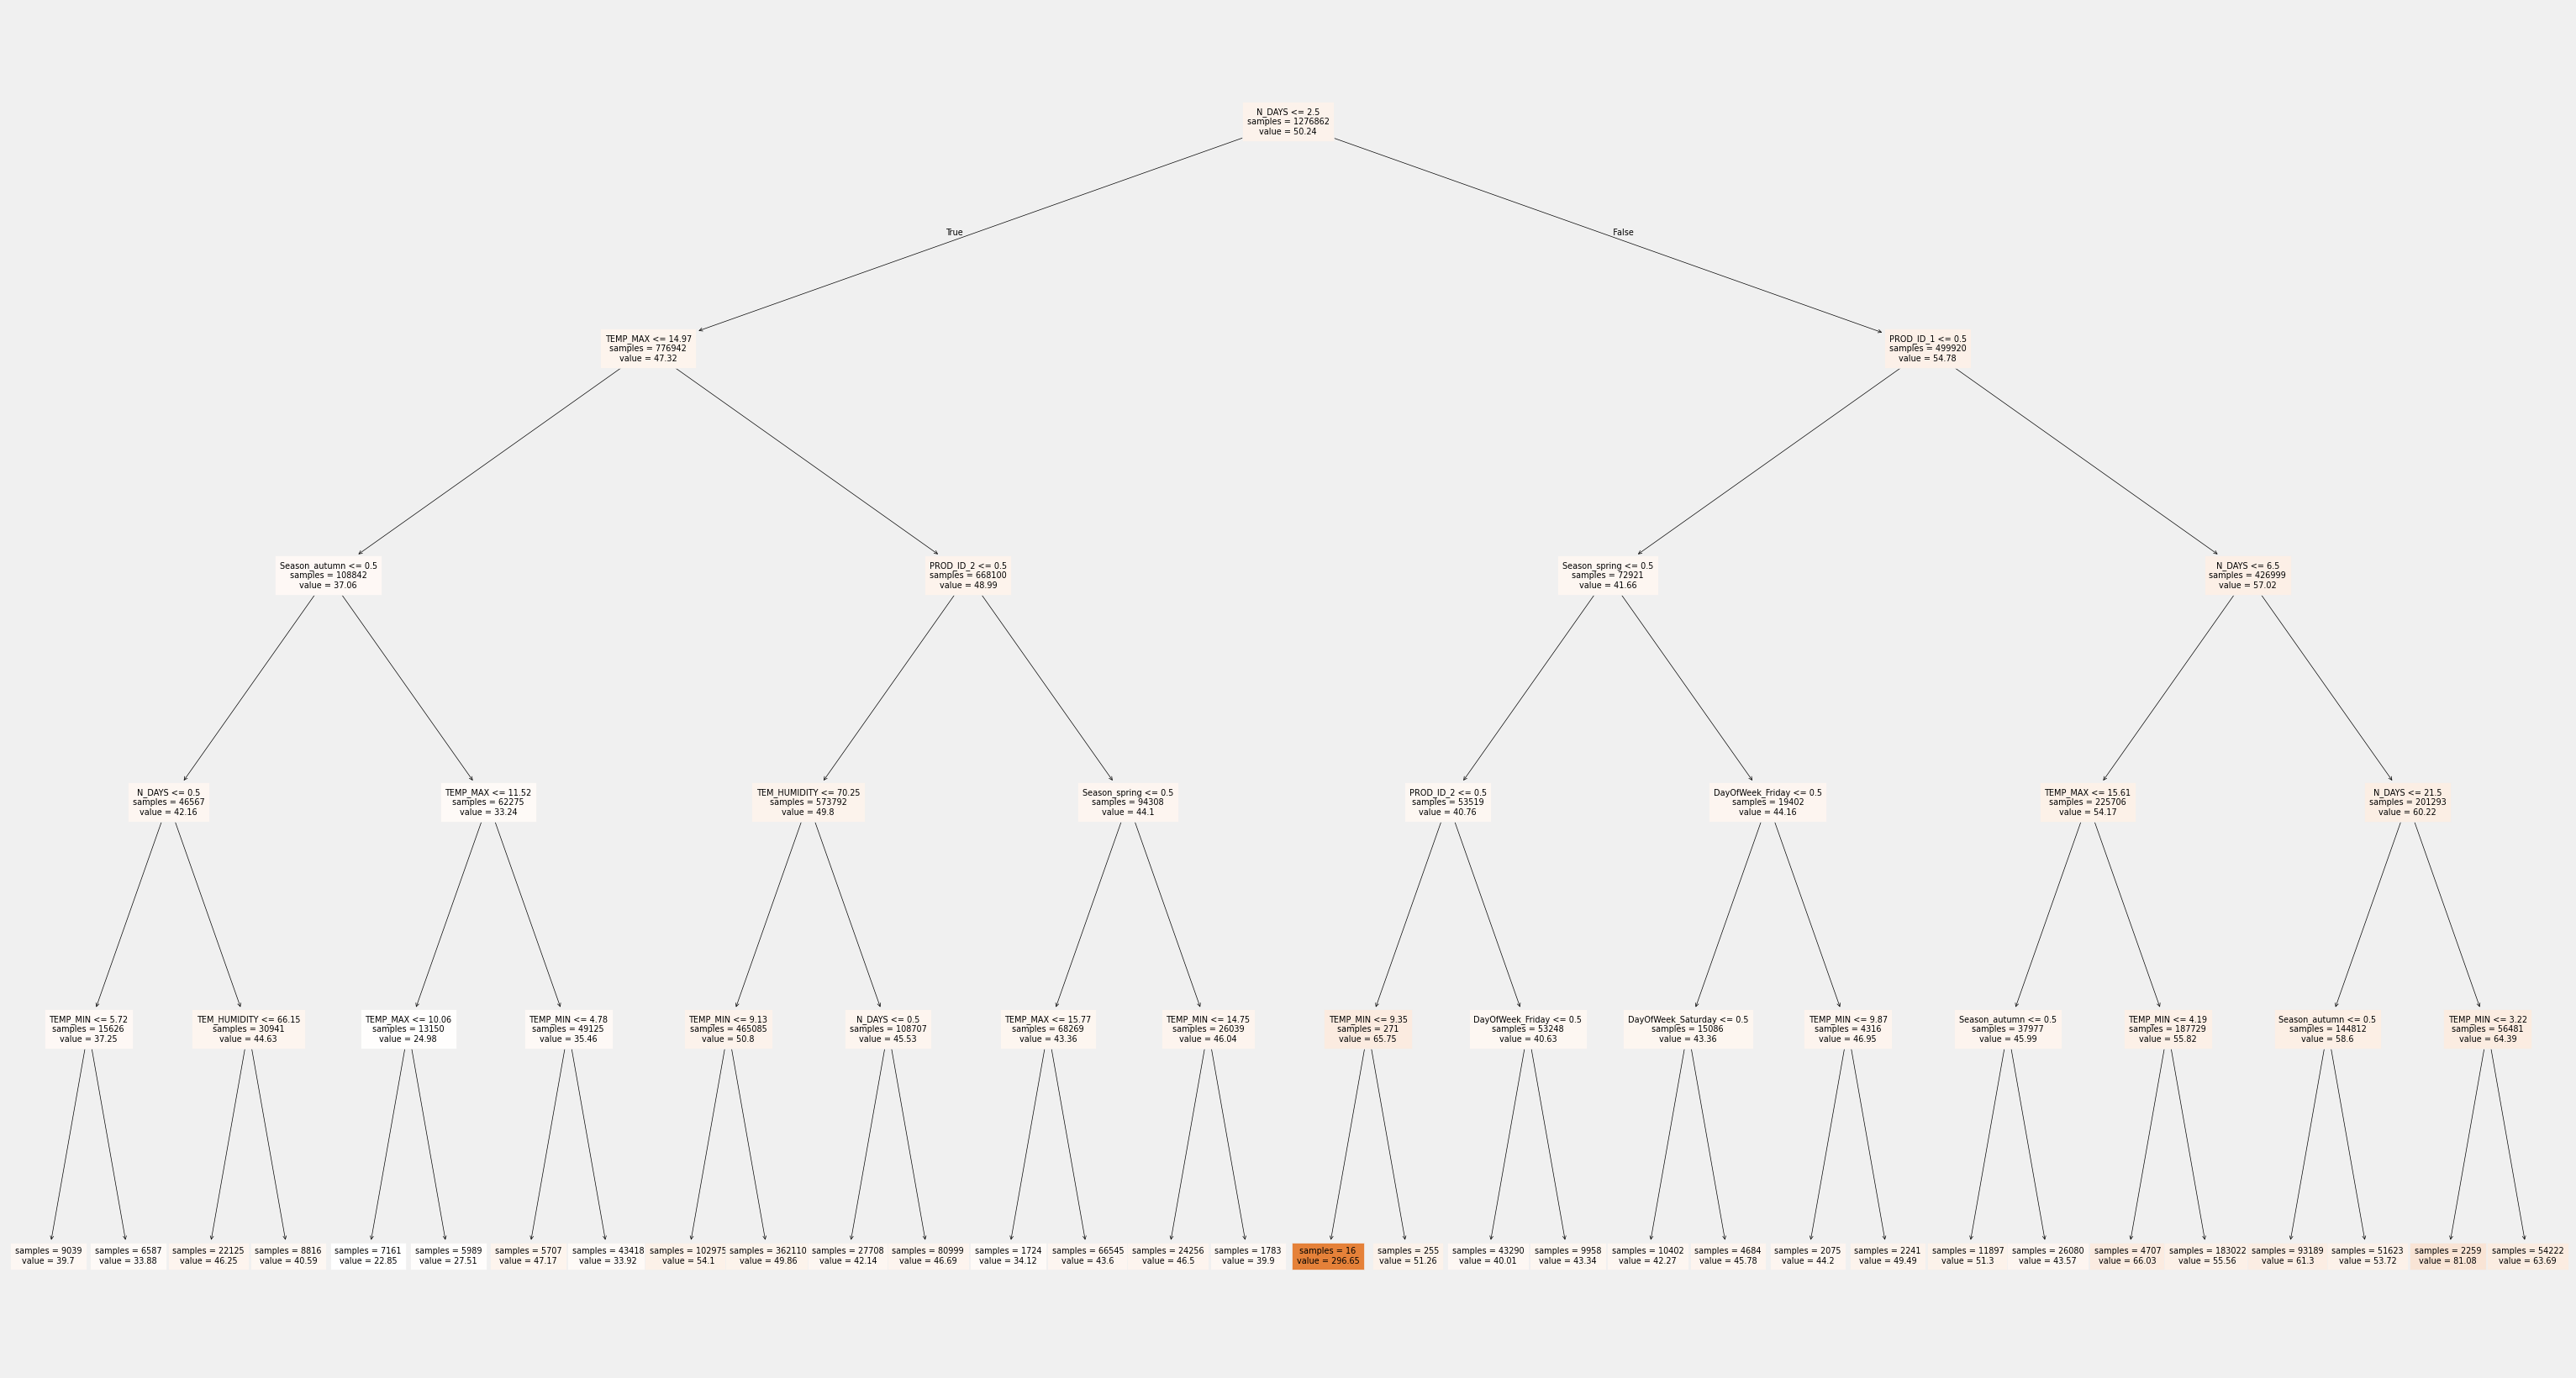

Reglas de decisión modelo inicial:
|--- N_DAYS <= 2.50
|   |--- TEMP_MAX <= 14.97
|   |   |--- Season_autumn <= 0.50
|   |   |   |--- N_DAYS <= 0.50
|   |   |   |   |--- TEMP_MIN <= 5.72
|   |   |   |   |   |--- value: [39.70]
|   |   |   |   |--- TEMP_MIN >  5.72
|   |   |   |   |   |--- value: [33.88]
|   |   |   |--- N_DAYS >  0.50
|   |   |   |   |--- TEM_HUMIDITY <= 66.15
|   |   |   |   |   |--- value: [46.25]
|   |   |   |   |--- TEM_HUMIDITY >  66.15
|   |   |   |   |   |--- value: [40.59]
|   |   |--- Season_autumn >  0.50
|   |   |   |--- TEMP_MAX <= 11.52
|   |   |   |   |--- TEMP_MAX <= 10.06
|   |   |   |   |   |--- value: [22.85]
|   |   |   |   |--- TEMP_MAX >  10.06
|   |   |   |   |   |--- value: [27.51]
|   |   |   |--- TEMP_MAX >  11.52
|   |   |   |   |--- TEMP_MIN <= 4.78
|   |   |   |   |   |--- value: [47.17]
|   |   |   |   |--- TEMP_MIN >  4.78
|   |   |   |   |   |--- value: [33.92]
|   |--- TEMP_MAX >  14.97
|   |   |--- PROD_ID_2 <= 0.50
|   |   |   |--- TEM

In [ ]:
print(f"\nCreando modelo Árbol de regresión para el conjunto de datos unificado:")

# Preprocesamos el dataframe que usaremos para el modelo
df_ajustado = preprocessor.fit_transform(df_c)   

# Especificamos las variables predictoras y objetivo
x = df_ajustado.drop(columns=['PRICE_FINAL'] )
y = df_ajustado['PRICE_FINAL']
    
# División de los datos en train (80%) y test (20%)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1, shuffle=True)

# Creación del modelo inicial
modelo_T = DecisionTreeRegressor(
    max_depth=5,
    random_state=123
)

# Entrenamiento del modelo inicial
modelo_T.fit(x_train, y_train)

# Estructura del árbol creado
fig, ax = plt.subplots(figsize=(35, 20))
print(f"Profundidad del árbol: {modelo_T.get_depth()}")
print(f"Número de nodos terminales: {modelo_T.get_n_leaves()}")

plot_tree(
    decision_tree=modelo_T,
    feature_names=list(x_train.columns),
    filled=True,
    impurity=False,
    fontsize=7,
    precision=2,
    ax=ax
)

# Guardamos la imagen con alta calidad
plt.savefig(f"arbol_decision.png", dpi=300, bbox_inches='tight')
plt.show()

# Explicabilidad del modelo
# Reglas de decisión
texto_modelo_T = export_text(
    decision_tree=modelo_T,
    feature_names=list(x_train.columns)
)
print('Reglas de decisión modelo inicial:')
print(texto_modelo_T)

# Importancia de los predictores
importancia_predictores_T = pd.DataFrame(
    {'predictor': x_train.columns, 'importancia': modelo_T.feature_importances_}
)
print("Importancia de los predictores en el modelo inicial")
print("-------------------------------------------")
print(importancia_predictores_T.sort_values('importancia', ascending=False))

# Pruning (cost complexity pruning) por validación cruzada
param_grid = {'ccp_alpha': np.linspace(0, 80, 20)}

grid = GridSearchCV(
    estimator=DecisionTreeRegressor(
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=123
    ),
    param_grid=param_grid,
    cv=10,
    refit=True,
    return_train_score=True
)

grid.fit(x_train, y_train)

# Mejor valor ccp_alpha encontrado
print('Mejores parámetros encontrados:')
print(grid.best_params_)

# Estructura del árbol final
modelo_final_T = grid.best_estimator_
print(f"Profundidad del árbol: {modelo_final_T.get_depth()}")
print(f"Número de nodos terminales: {modelo_final_T.get_n_leaves()}")

fig, ax = plt.subplots(figsize=(10, 7))
plot_tree(
    decision_tree=modelo_final_T,
    feature_names=list(x_train.columns),
    filled=True,
    impurity=False,
    fontsize = 10,
    ax=ax
)

# Guardar la imagen con alta calidad
plt.savefig(f"arbol_decision_podado.png", dpi=300, bbox_inches='tight')
plt.show()

# Explicabilidad del modelo
# Reglas de decisión
#texto_modelo_final_T = export_text(
#    decision_tree=modelo_final_T,
#    feature_names=list(x_train.columns)
#)
#print('Reglas de decisión modelo final:')
#print(texto_modelo_final_T)

# Importancia de los predictores
importancia_predictores_final_T = pd.DataFrame(
    {'predictor': x_train.columns, 'importancia': modelo_final_T.feature_importances_}
)
print("Importancia de los predictores en el modelo final")
print("-------------------------------------------")
print(importancia_predictores_final_T.sort_values('importancia', ascending=False))


# Error de test del modelo inicial
predicciones = modelo_T.predict(x_test)
rmse = mean_squared_error(y_true=y_test, y_pred=predicciones, squared=False)
print(f"El error (rmse) de test del modelo inicial es: {rmse}")

# Error de test del modelo final (tras aplicar pruning)
predicciones = modelo_final_T.predict(x_test)
rmse = mean_squared_error(y_true=y_test, y_pred=predicciones, squared=False)
print(f"El error (rmse) de test del modelo final es: {rmse}")

## Modelo 2: Random Forest

In [ ]:
print(f"\nCreando modelo bosque de regresión para el dataset unificado: {producto}")

# Filtramos los datos para el tipo de producto actual
df_ajustado = preprocessor.fit_transform(df_c)   

# Especificamos las variables predictoras y objetivo
x = df_ajustado.drop(columns=['PRICE_FINAL'])
y = df_ajustado['PRICE_FINAL']

# División de los datos en train (80%) y test (20%)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1, shuffle=True)

# Creación del modelo inicial
modelo_RF = RandomForestRegressor(
            n_estimators = 10,
            criterion    = 'squared_error',
            max_depth    = None,
            max_features = 1,
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )

# Entrenamiento del modelo
# ==============================================================================
modelo_RF.fit(x_train, y_train)

# Error de test del modelo inicial
# ==============================================================================
predicciones_RF = modelo_RF.predict(X=x_test)
mse = mean_squared_error(y_true=y_test, y_pred=predicciones_RF)
rmse = np.sqrt(mse)
print(f"El error (rmse) de test del primer modelo es: {rmse}")

# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'n_estimators': [150],
                 'max_features': [5, 7, 9],
                 'max_depth'   : [None, 3, 10, 20]
                }

# Creamos el GridSearchCV
grid_search = GridSearchCV(
    estimator=modelo_RF,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

# Ajustamos el modelo
grid_search.fit(x_train, y_train)

# Resultados de los mejores hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Modelo final
modelo_final_RF = grid_search.best_estimator_

# Predicciones y evaluación
predicciones = modelo_final_RF.predict(x_test)
mse = mean_squared_error(y_test, predicciones)
rmse = np.sqrt(mse)
print(f"El error (rmse) de test del modelo mejorado es: {rmse}")

# Importancia de los predictores basada en la reducción de la impureza
importancia_predictores = pd.DataFrame({
    'predictor': x_train.columns,
    'importancia': modelo_final_RF.feature_importances_
})
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
print(importancia_predictores.sort_values('importancia', ascending=False))

# Explicabilidad del modelo
# ==============================================================================
# Explicabilidad del modelo inicial
# Fits the explainer
explainer = shap.Explainer(modelo_RF.predict, x_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(x_test)
shap.plots.bar(shap_values)
    
# Explicabilidad del modelo final
# Fits the explainer
explainer = shap.Explainer(modelo_final_RF.predict, x_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(x_test)
shap.plots.bar(shap_values)